In [70]:
# import necessary libraries
import pandas as pd
import os
import sys
import warnings
import seaborn as sns
import numpy as np
import statsmodels.formula.api as smf
import plotly.express as px
from plotnine import *
from mizani.formatters import percent_format
import matplotlib.pyplot as plt

from scipy.stats import logistic
from scipy.stats import norm
from stargazer.stargazer import Stargazer
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss


warnings.filterwarnings("ignore")

In [2]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("DA2_2023")[0]

# Load prewritten functions
func = dirname + "DA2_2023/work-files/ch00-tech-prep/"
sys.path.append(func)

In [3]:
# Import the prewritten helper functions
from py_helper_functions import *

In [4]:
# import Prices and Features CSVs
prices = pd.read_csv("hotels-europe_price.csv")
features = pd.read_csv("hotels-europe_features.csv")

In [5]:
# Merge tables using hotel_id
df = prices.merge(features, on ="hotel_id")

In [6]:
df_naples = df.loc[df['city']=="Naples"]

In [7]:
df_naples.T

,83947,83948,83949,83950,83951,83952,83953,83954,83955,83956,...,87711,87712,87713,87714,87715,87716,87717,87718,87719,87720
hotel_id,11706,11706,11706,11706,11707,11707,11707,11707,11707,11707,...,12213,12213,12213,12213,12213,12213,12214,12214,12214,12214
price,278,69,69,69,43,72,49,43,49,181,...,76,81,76,76,81,76,81,81,349,81
offer,0,0,0,0,1,0,1,1,1,1,...,1,1,1,1,1,1,0,0,0,0
offer_cat,0% no offer,0% no offer,0% no offer,0% no offer,15-50% offer,0% no offer,15-50% offer,15-50% offer,15-50% offer,15-50% offer,...,1-15% offer,1-15% offer,1-15% offer,1-15% offer,1-15% offer,1-15% offer,0% no offer,0% no offer,0% no offer,0% no offer
year,2017,2017,2017,2017,2018,2018,2018,2018,2017,2017,...,2018,2017,2018,2017,2017,2018,2017,2017,2017,2017
month,12,11,12,11,1,3,5,4,11,12,...,3,12,5,11,11,4,12,11,12,11
weekend,0,0,0,1,1,1,1,1,1,0,...,1,0,1,1,0,1,0,0,0,1
holiday,1,0,1,0,0,0,0,0,0,1,...,0,1,0,0,0,0,1,0,1,0
nnights,4,1,1,1,1,1,1,1,1,4,...,1,1,1,1,1,1,1,1,4,1
scarce_room,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,0,0,1


In [8]:
df_naples.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3774 entries, 83947 to 87720
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   hotel_id            3774 non-null   int64  
 1   price               3774 non-null   int64  
 2   offer               3774 non-null   int64  
 3   offer_cat           3774 non-null   object 
 4   year                3774 non-null   int64  
 5   month               3774 non-null   int64  
 6   weekend             3774 non-null   int64  
 7   holiday             3774 non-null   int64  
 8   nnights             3774 non-null   int64  
 9   scarce_room         3774 non-null   int64  
 10  city                3774 non-null   object 
 11  distance            3774 non-null   float64
 12  stars               1474 non-null   float64
 13  rating              3284 non-null   float64
 14  country             3774 non-null   object 
 15  city_actual         3774 non-null   object 
 16  r

In [9]:
# look at our df
df_naples.columns

Index(['hotel_id', 'price', 'offer', 'offer_cat', 'year', 'month', 'weekend',
       'holiday', 'nnights', 'scarce_room', 'city', 'distance', 'stars',
       'rating', 'country', 'city_actual', 'rating_reviewcount',
       'center1label', 'center2label', 'neighbourhood', 'ratingta',
       'ratingta_count', 'distance_alter', 'accommodation_type'],
      dtype='object')

In [10]:
# Check for null values
print(f'''There are {df_naples["rating"].shape[0]} values in the column out of which {df_naples["rating"].isnull().sum()} are null.      
We have {df_naples["rating"].count()} non-empty cells.''')

There are 3774 values in the column out of which 490 are null.      
We have 3284 non-empty cells.


In [11]:
df_naples.dropna(subset=['rating'], inplace=True)

In [12]:
# use hotel user ratings to create a binary variable: highly_rated=1 if rating ≥ 4, 0 otherwise
df_naples['highly_rated'] = [1 if r >= 4 else 0 for r in df_naples['rating']]

In [13]:
df_naples['highly_rated'].value_counts()

1    1820
0    1464
Name: highly_rated, dtype: int64

In [14]:
f'There are {df_naples["hotel_id"].nunique()} uniqe hotels in this table.'

'There are 435 uniqe hotels in this table.'

## Null values 
# We need to decide what to do with these

In [15]:
null_count = df_naples['stars'].isnull().sum()
print(f"Number of null values in the 'stars' column: {null_count}")

Number of null values in the 'stars' column: 1820


In [16]:
df_naples.dropna(subset=['stars'], inplace=True)

Task 1. Examine how high rating is related to the other hotel features in the data
- price (ln?)
- distance
- stars
- rating-reviewcount?
- neighbourhood

    Which ones should we look at?


### Price Filtering

In [17]:
# Check for null values
df_naples['price'].isnull().sum()

0

<Axes: title={'center': 'Fig1: Price Distribution'}, xlabel='Price', ylabel='Number of Accomodations'>

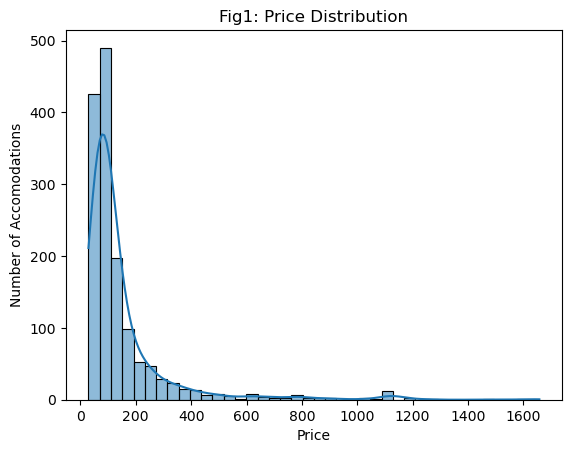

In [18]:
# Make a hist of the prices from the raw data
fig1 = sns.histplot(df_naples['price'],bins=40 ,kde=True)
fig1.set(title='Fig1: Price Distribution', xlabel='Price', ylabel='Number of Accomodations')
fig1

In [19]:
# Get an idea about outliers
df_naples['price'].describe(percentiles=[0.5,0.95])

count    1464.000000
mean      148.096995
std       178.127271
min        29.000000
50%        91.000000
95%       433.550000
max      1658.000000
Name: price, dtype: float64

In [20]:
# filter out outliers, which are probably errors or luxury hotels
filtered_naples = df_naples.loc[df_naples['price'] <= 450]

<Axes: title={'center': 'Fig2: Filtered Price Distribution'}, xlabel='Price', ylabel='Number of Accomodations'>

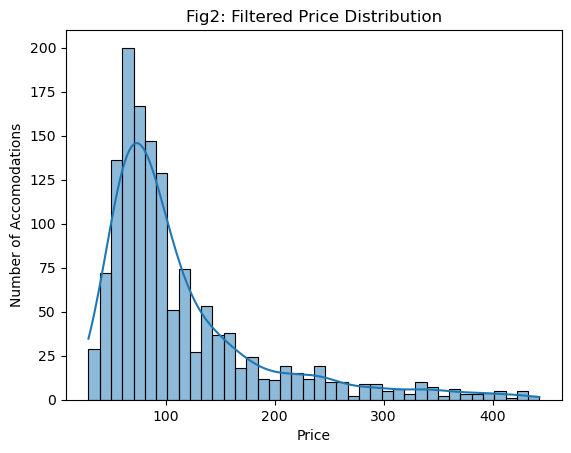

In [21]:
# Make a hist of the prices without outliers
fig2 = sns.histplot(filtered_naples['price'],bins=40 ,kde=True)
fig2.set(title='Fig2: Filtered Price Distribution', xlabel='Price', ylabel='Number of Accomodations')
fig2

In [22]:
# create log price
filtered_naples["lnp"] = np.log(filtered_naples["price"])

<Axes: title={'center': 'Fig3: Natural Logarithm of Price Distribution'}, xlabel='Ln Price', ylabel='Number of Accomodations'>

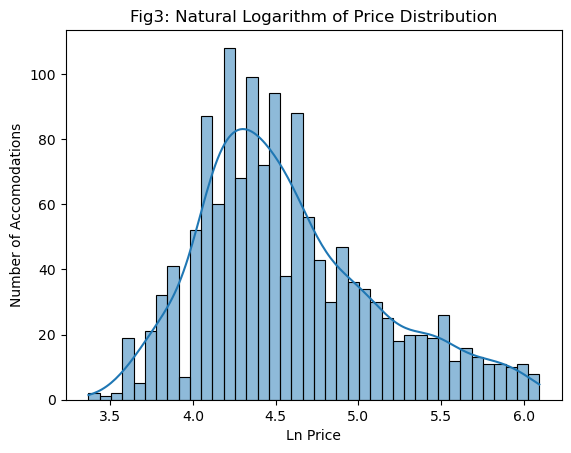

In [23]:
fig3 = sns.histplot(filtered_naples["lnp"],bins=40 ,kde=True)
fig3.set(title='Fig3: Natural Logarithm of Price Distribution', xlabel='Ln Price', ylabel='Number of Accomodations')
fig3

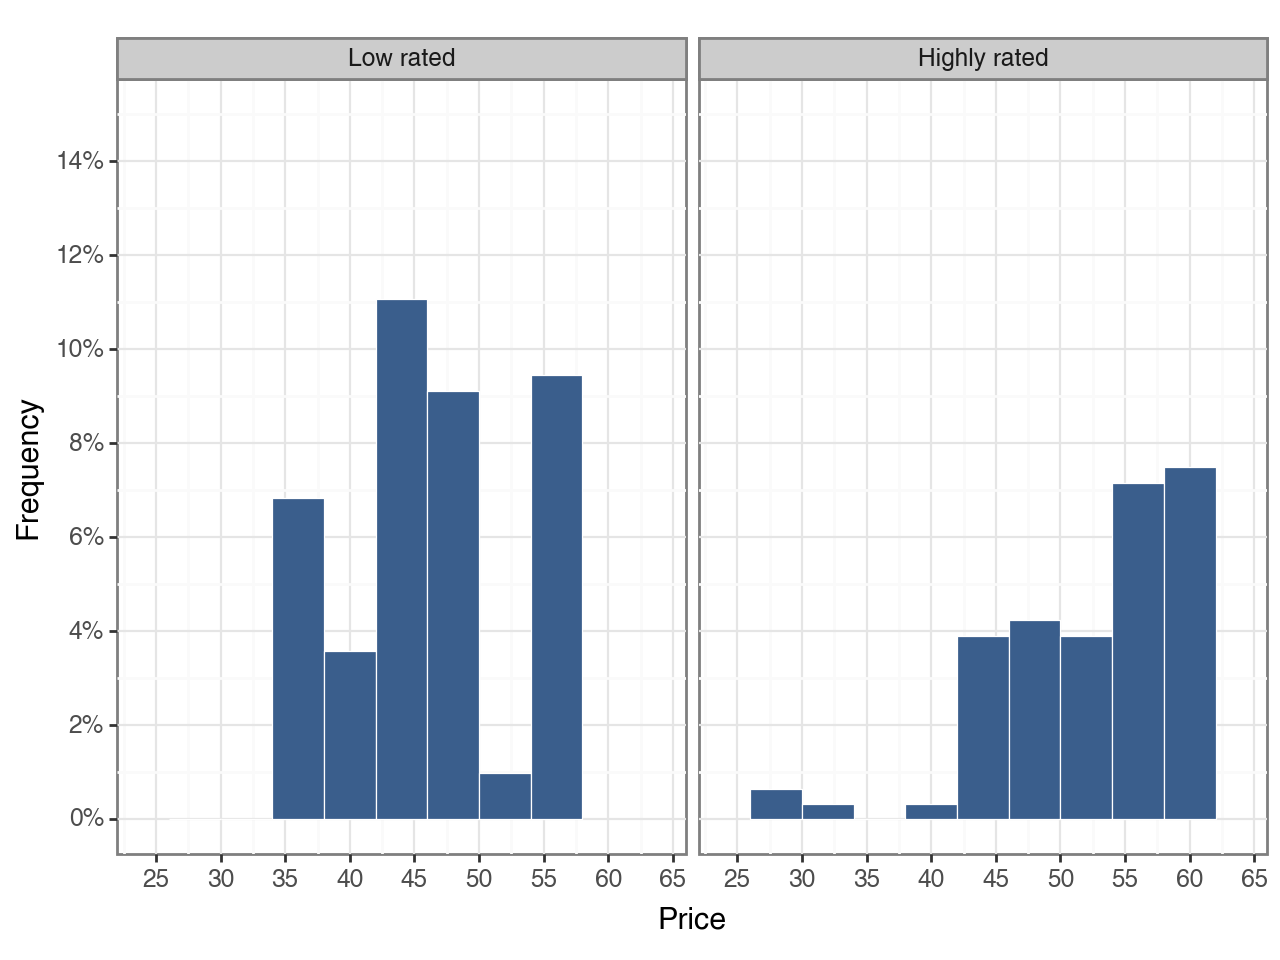

<Figure Size: (640 x 480)>

In [24]:
# Plot Price Distribution seperately for high and low rated
(
    ggplot(filtered_naples, aes(x="price", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=4,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
    )
    + facet_wrap("~highly_rated", labeller={"0": "Low rated", "1": "Highly rated"})
    + labs(x="Price", y="Frequency")
    + scale_x_continuous(
        limits=(24, 64),
        breaks=seq(25, 65, by=5),
    )
    + scale_y_continuous(
        limits=(0, 0.15), breaks=seq(0, 0.15, by=0.02), labels=percent_format()
    )
    + theme_bw()
)

## Distance filtering

In [25]:
# Check for null values
filtered_naples['distance'].isnull().sum()

0

<Axes: title={'center': 'Fig4: Distance Distribution'}, xlabel='Distance', ylabel='Number of Accomodations'>

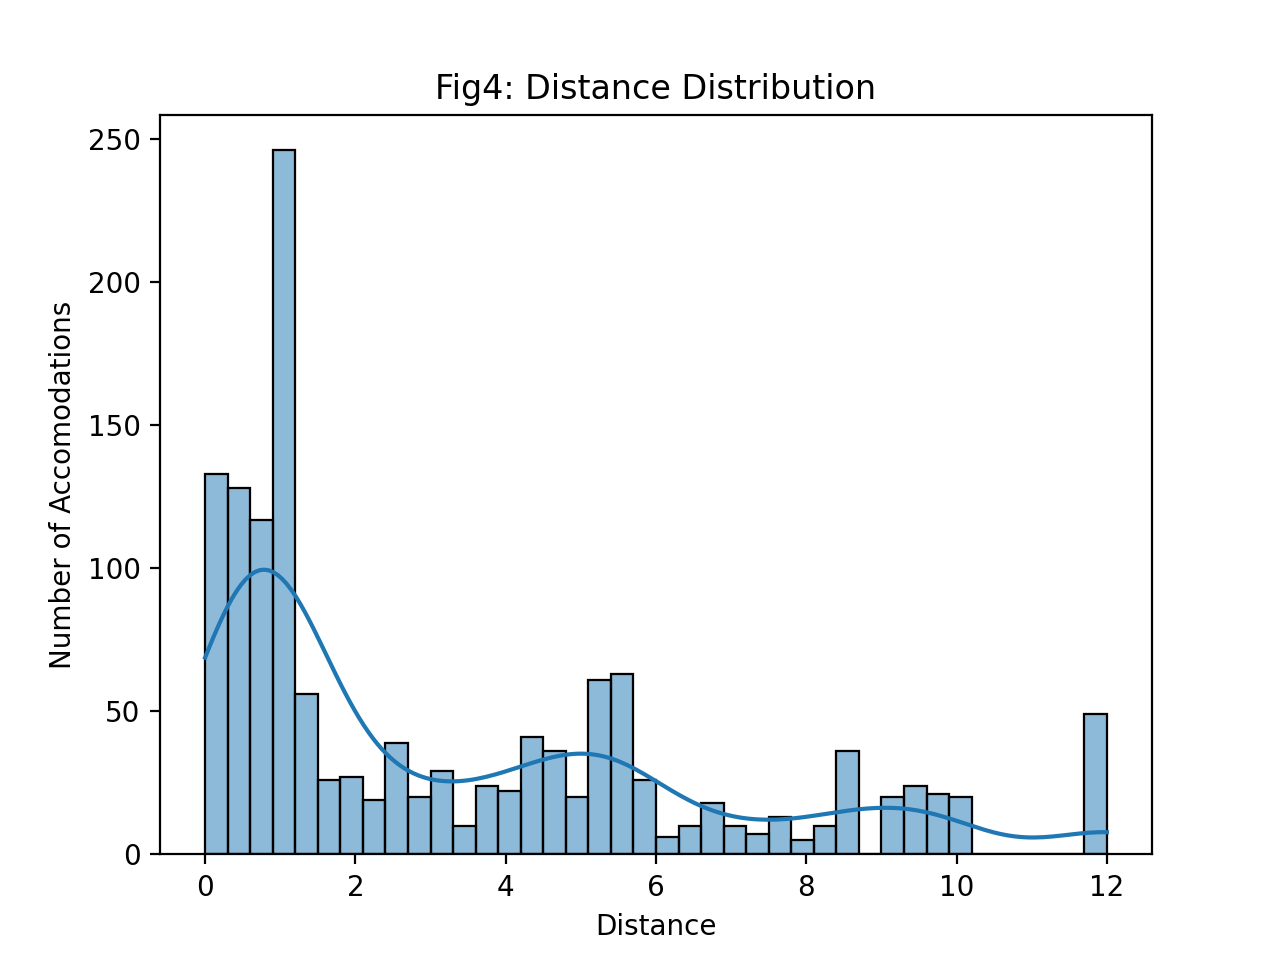

In [26]:
# Make a hist of the distance from the price filtered data
fig4 = sns.histplot(filtered_naples['distance'],bins=40 ,kde=True)
fig4.set(title='Fig4: Distance Distribution', xlabel='Distance', ylabel='Number of Accomodations')
fig4

In [27]:
# Get an idea about outliers
filtered_naples['distance'].describe(percentiles=[0.5,0.95])

count    1392.000000
mean        3.290733
std         3.275277
min         0.000000
50%         1.650000
95%         9.800000
max        12.000000
Name: distance, dtype: float64

In [28]:
# filter out outliers, which are probably errors (very far from city centre)
filtered_naples = filtered_naples.loc[filtered_naples['distance'] <= 9.5]

<Axes: title={'center': 'Fig5: Distance Distribution'}, xlabel='Distance', ylabel='Number of Accomodations'>

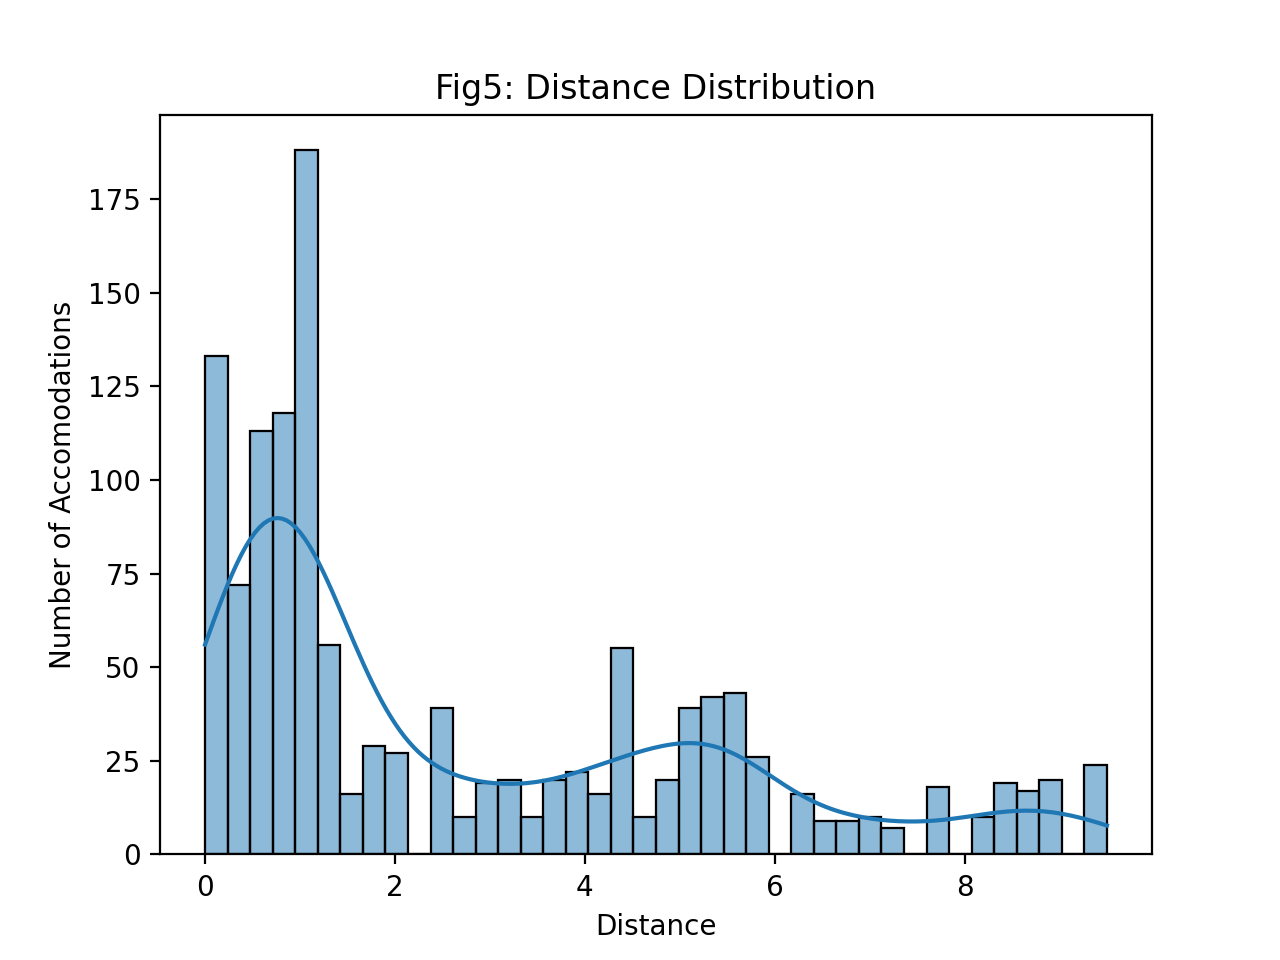

In [29]:
# Make a hist of the distance from the filtered data
fig5 = sns.histplot(filtered_naples['distance'],bins=40 ,kde=True)
fig5.set(title='Fig5: Distance Distribution', xlabel='Distance', ylabel='Number of Accomodations')
fig5

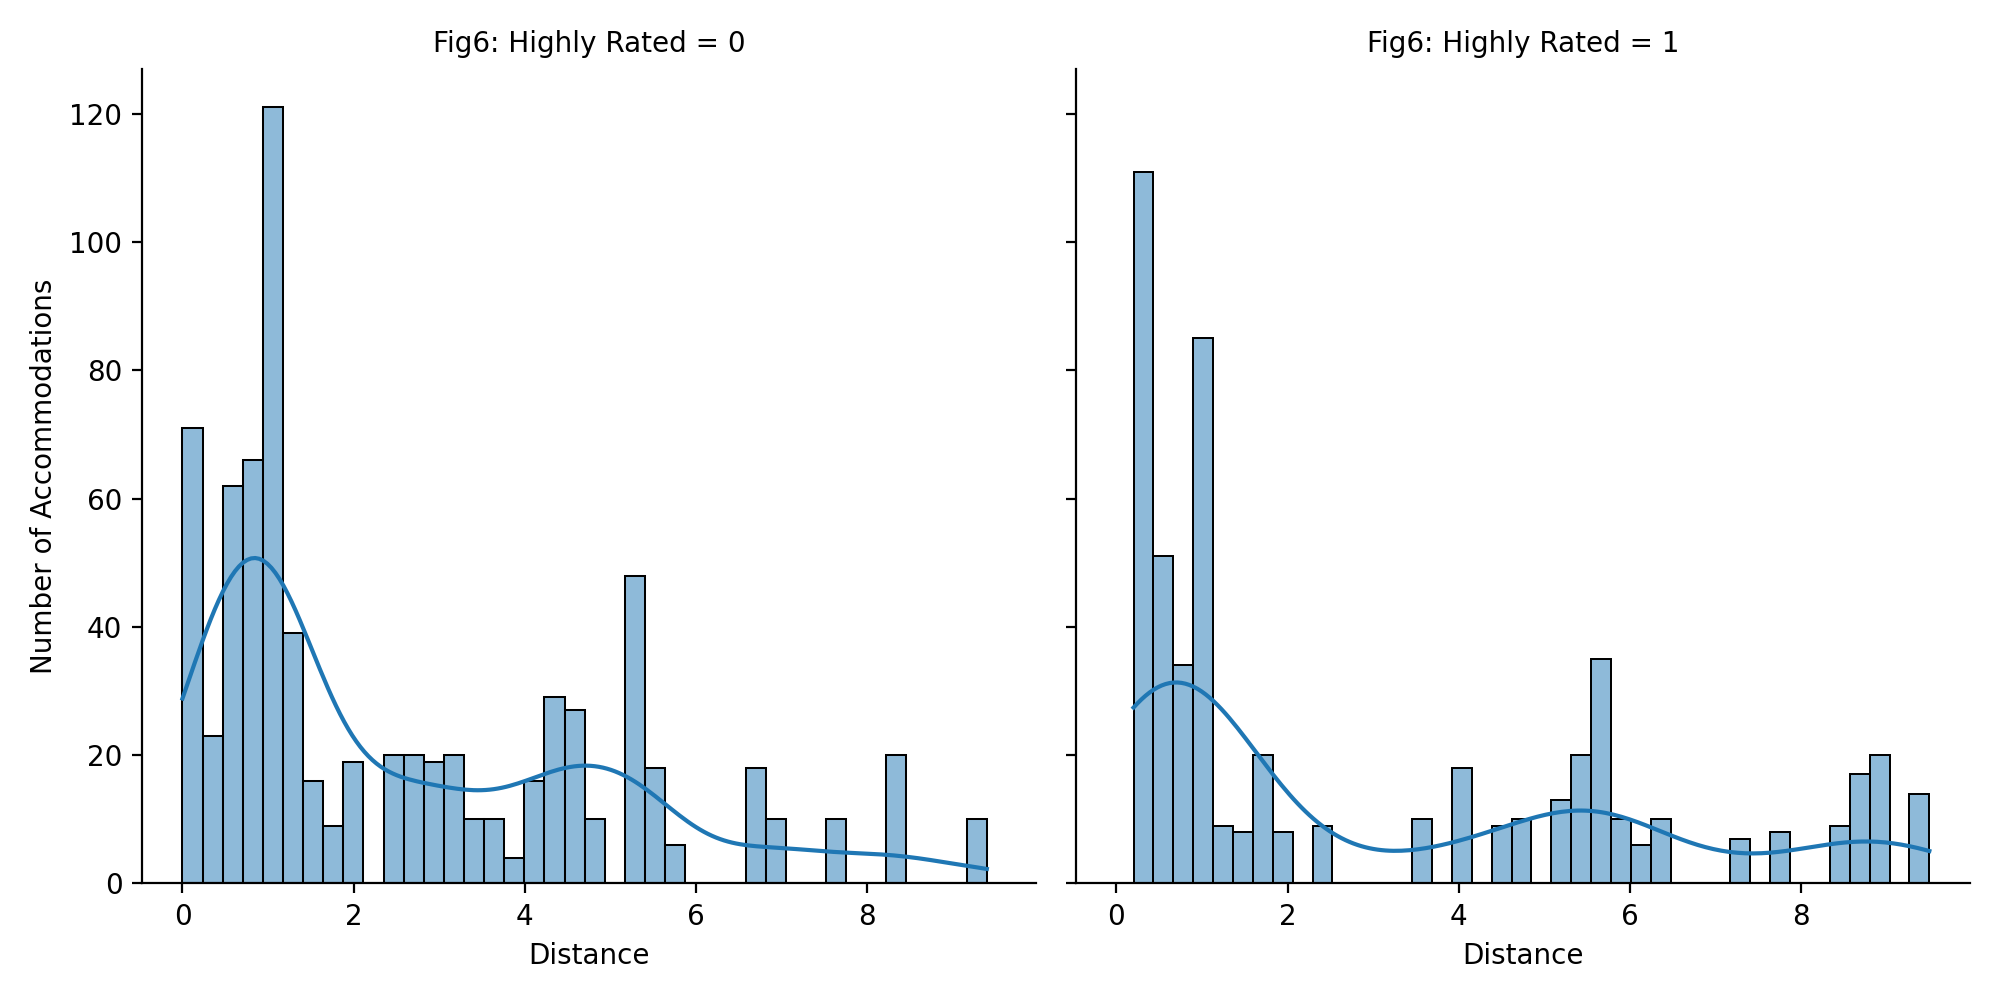

In [30]:
# Create a FacetGrid in sns
grid = sns.FacetGrid(filtered_naples, col='highly_rated', height=5)
grid.map(sns.histplot, 'distance', bins=40, kde=True)

grid.set_titles(col_template='Fig6: Highly Rated = {col_name}')
grid.set_axis_labels(x_var='Distance', y_var='Number of Accommodations')

plt.show()

## Stars filtering

In [31]:
# Check for null values
print(f'''There are {filtered_naples["stars"].shape[0]} values in the column out of which {filtered_naples["stars"].isnull().sum()} are null.      
We have {filtered_naples["stars"].count()} non-empty cells.''')

There are 1302 values in the column out of which 0 are null.      
We have 1302 non-empty cells.


In [32]:
filtered_naples['stars'].value_counts().reset_index().sort_values(by='index')

,index,stars
2,1.0,57
3,2.0,46
0,3.0,590
5,3.5,13
1,4.0,570
4,5.0,26


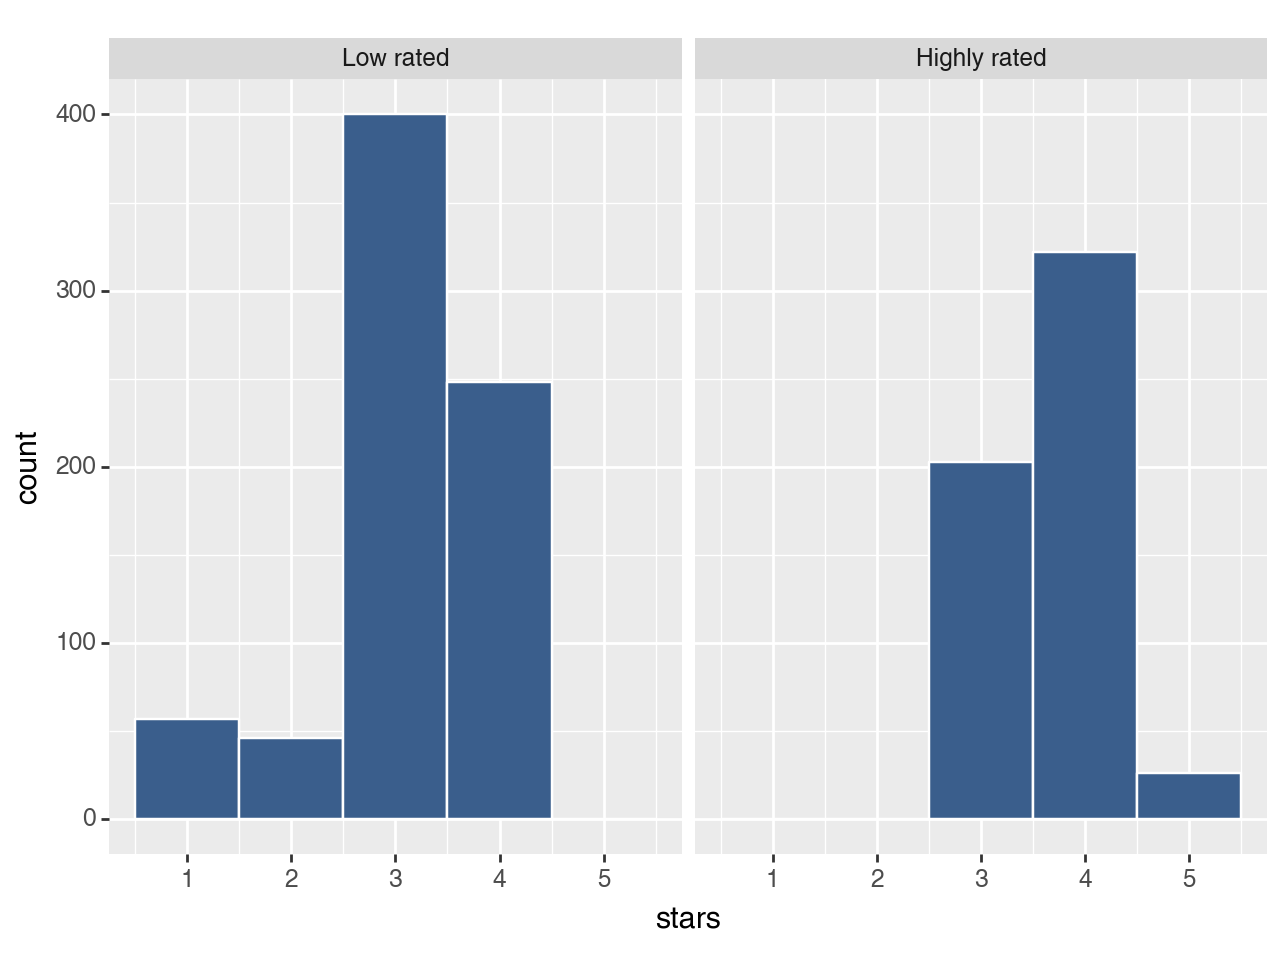

<Figure Size: (640 x 480)>

In [33]:
# Plot the distribution of stars
(ggplot(filtered_naples, aes(x="stars"))
 + geom_histogram(
     binwidth=1,
        color="white",
        fill=color[0])
+ facet_wrap("~highly_rated", labeller={"0": "Low rated", "1": "Highly rated"}))

In [34]:
# No need for filtering in this column

## Model 1

In [35]:
# Fit the regression model
reg1 = smf.ols(formula='price~highly_rated', data=filtered_naples).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     67.60
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           4.81e-16
Time:                        15:46:23   Log-Likelihood:                -7456.6
No. Observations:                1302   AIC:                         1.492e+04
Df Residuals:                    1300   BIC:                         1.493e+04
Df Model:                           1                                         
Covariance Type:                  HC1                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      101.7270      2.622     38.802      0.000      96.589     106.865
highly_rated    34.7013      4.221      8.222      0.000      26.429      42.974
==============================================================================
Omnibus:                      528.384   Durbin-Watson:                   1.589
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1894.539
Skew:                           2.016   Prob(JB):                         0.00
Kurtosis:                       7.320   Cond. No.                         2.48
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [36]:
# Fit the regression model
reg1 = smf.ols(formula='highly_rated~price', data=filtered_naples).fit(cov_type="HC1")
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           highly_rated   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     54.97
Date:                Mon, 04 Dec 2023   Prob (F-statistic):           2.20e-13
Time:                        15:46:23   Log-Likelihood:                -895.66
No. Observations:                1302   AIC:                             1795.
Df Residuals:                    1300   BIC:                             1806.
Df Model:                           1                                         
Covariance Type:                  HC1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2536      0.025     10.112      0.000       0.204       0.303
price          0.0015      0.000      7.414      0.000       0.001       0.002
==============================================================================
Omnibus:                     6271.301   Durbin-Watson:                   0.319
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.318
Skew:                           0.276   Prob(JB):                     1.04e-37
Kurtosis:                       1.316   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [37]:
# lowess for splines


<Axes: >

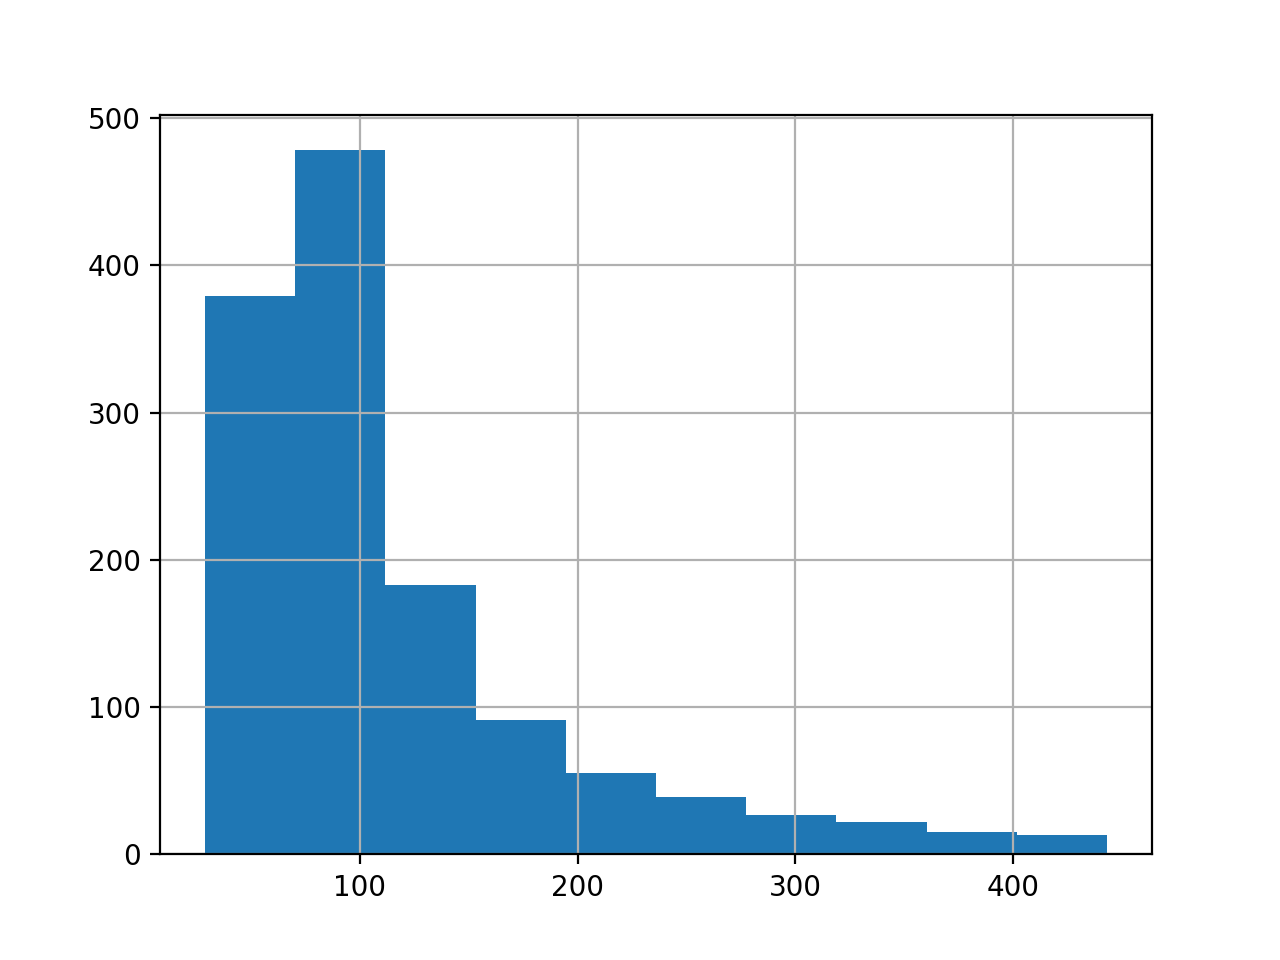

In [38]:
filtered_naples = filtered_naples.loc[df_naples['price'] <= 450]
filtered_naples.price.hist()

In [39]:
filtered_naples['price'].isnull().sum()

0

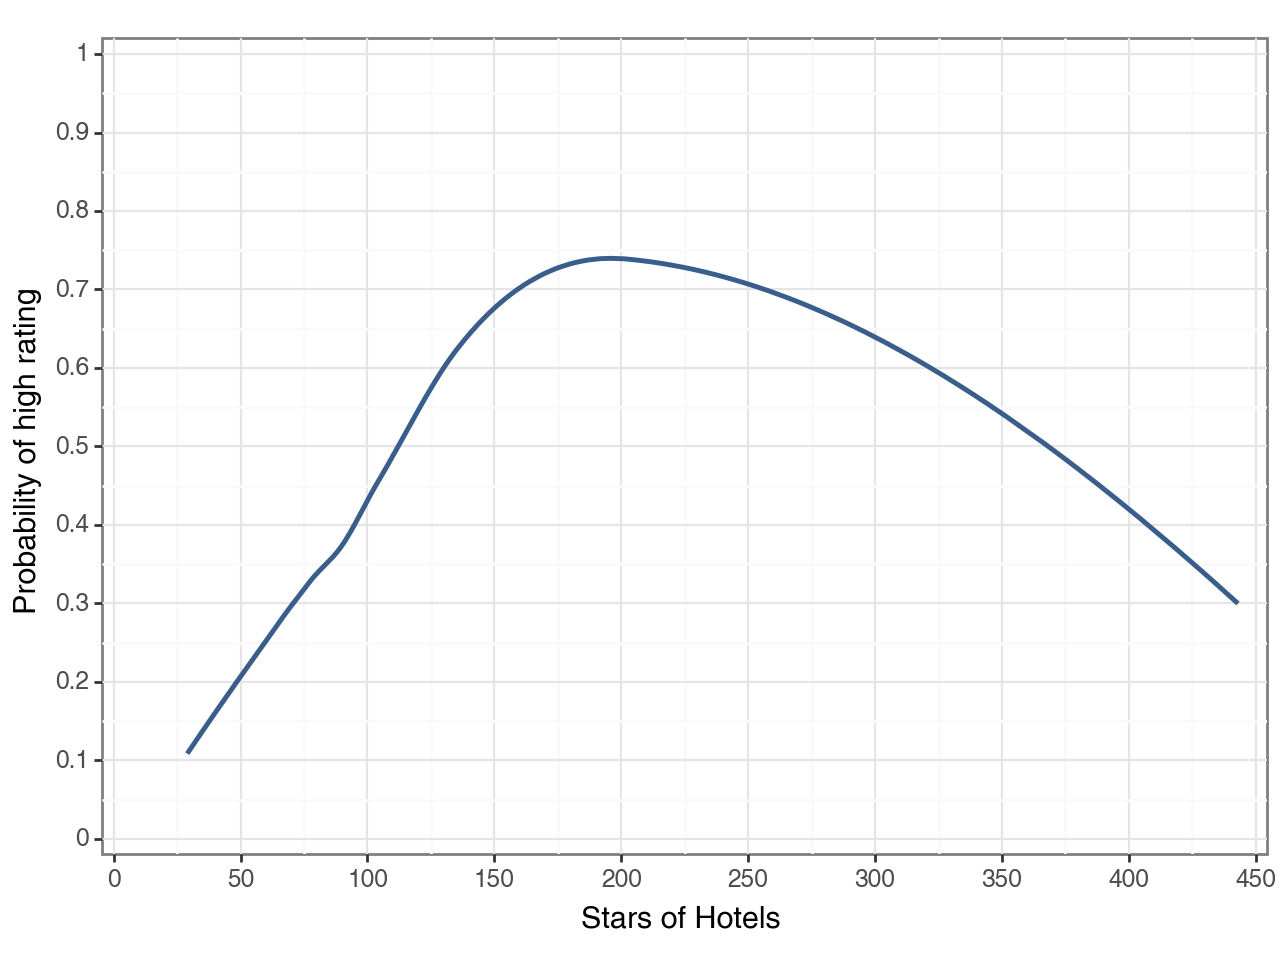

<Figure Size: (640 x 480)>

In [40]:
#we should calc average price!!!
g2a = (
    ggplot(data=filtered_naples)
    + geom_smooth(
        aes(x="price", y="highly_rated"), method="loess", se=False, color=color[0]
    )
    + labs(
       x="Price ", y="Probability of high rating "
    )
    # + coord_cartesian(xlim = [0, 1], ylim=[0,1])
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 450], breaks=seq(0, 450, 50))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2a

In [41]:
filtered_naples['distance'].isnull().sum()

0

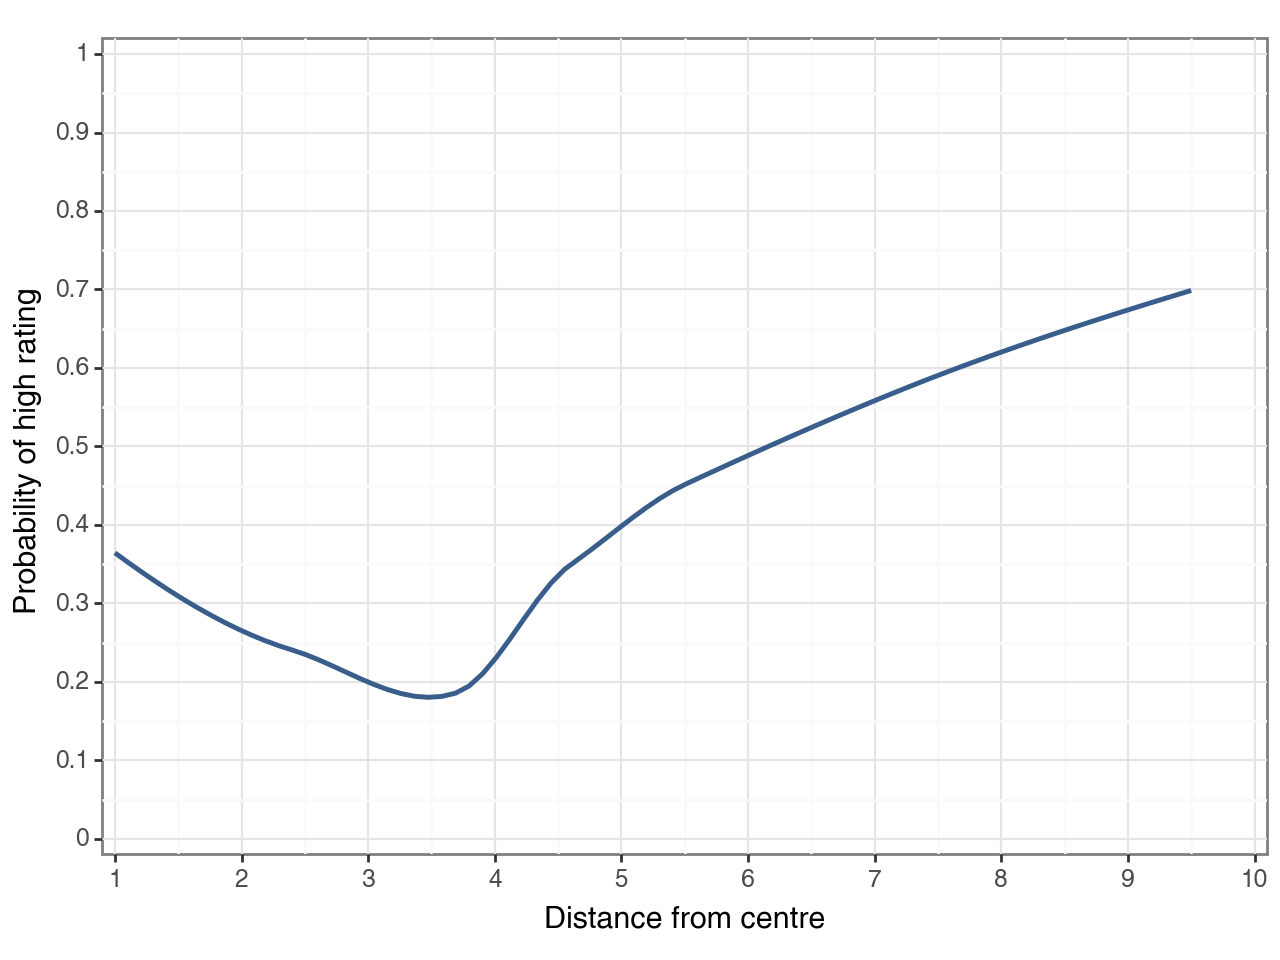

<Figure Size: (640 x 480)>

In [42]:
g2b = (
    ggplot(data=filtered_naples)
    + geom_smooth(
        aes(x="distance", y="highly_rated"), method="loess", se=False, color=color[0]
    )
    + labs(
       x="Distance from centre", y="Probability of high rating "
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 10], breaks=seq(0, 10, 1))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=seq(0, 1, 0.1))
    + theme_bw()
)
g2b

In [43]:
filtered_naples['stars'].isnull().sum()

0

In [44]:
filtered_naples['hotel_id'].value_counts()

11766    10
12197    10
12141    10
12138    10
12137    10
         ..
11978     2
11955     2
11862     1
11919     1
11996     1
Name: hotel_id, Length: 162, dtype: int64

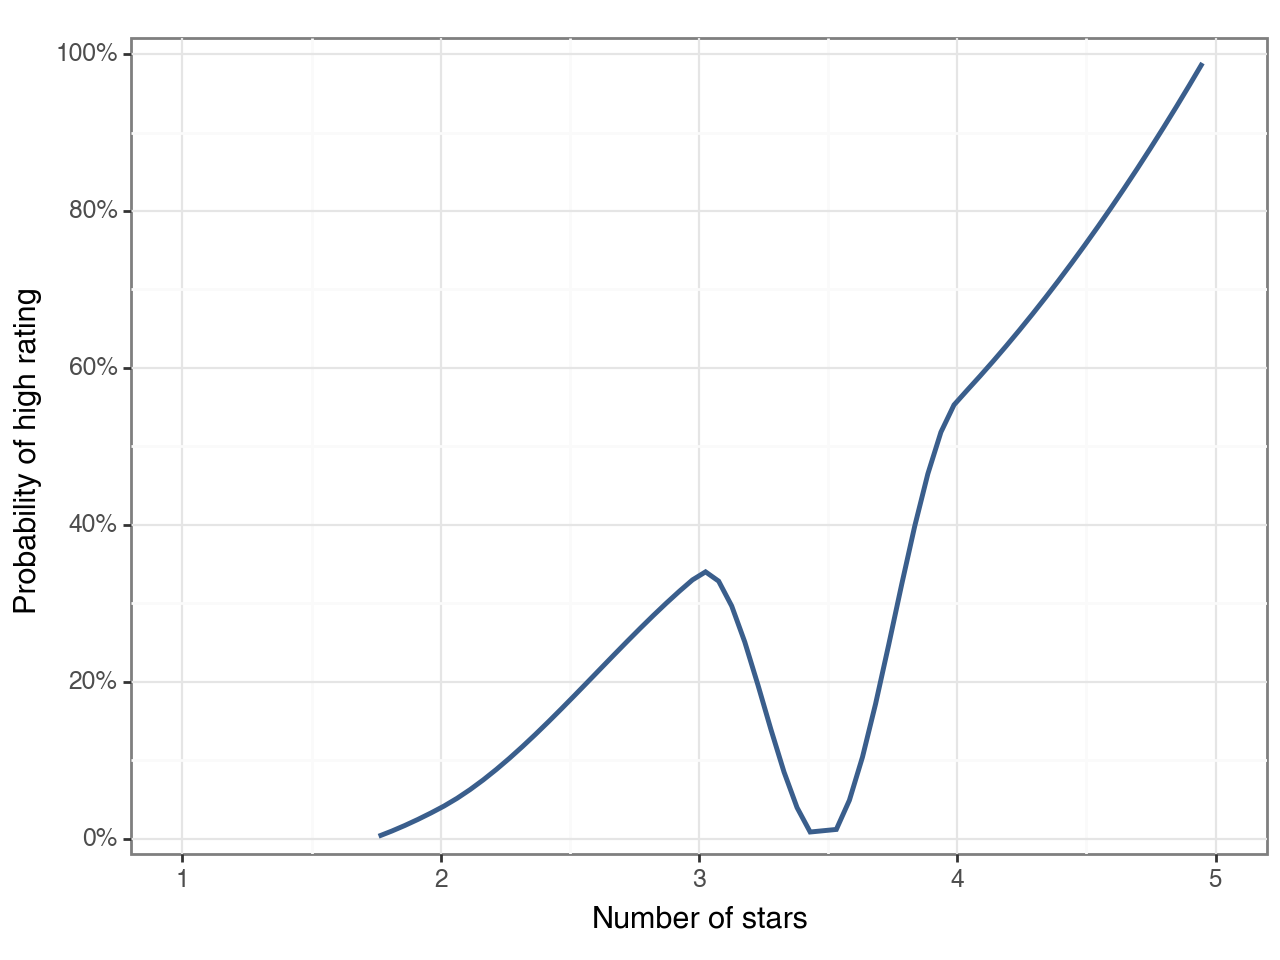

<Figure Size: (640 x 480)>

In [52]:
g2c = (
    ggplot(data=filtered_naples)
    + geom_smooth(
        aes(x="stars", y="highly_rated"), method="loess", se=False, color=color[0], span = 0.95
    )
    + scale_y_continuous(
        expand=[0.01, 0.01],
        limits=[0, 1],
        breaks=seq(0, 1, 0.2),
        labels=percent_format(),
    )
    + labs(x="Number of stars", y="Probability of high rating ")
    + theme_bw()
)
g2c

<Axes: title={'center': 'Fig1: Star Distribution'}, xlabel='Star', ylabel='Number of Accomodations'>

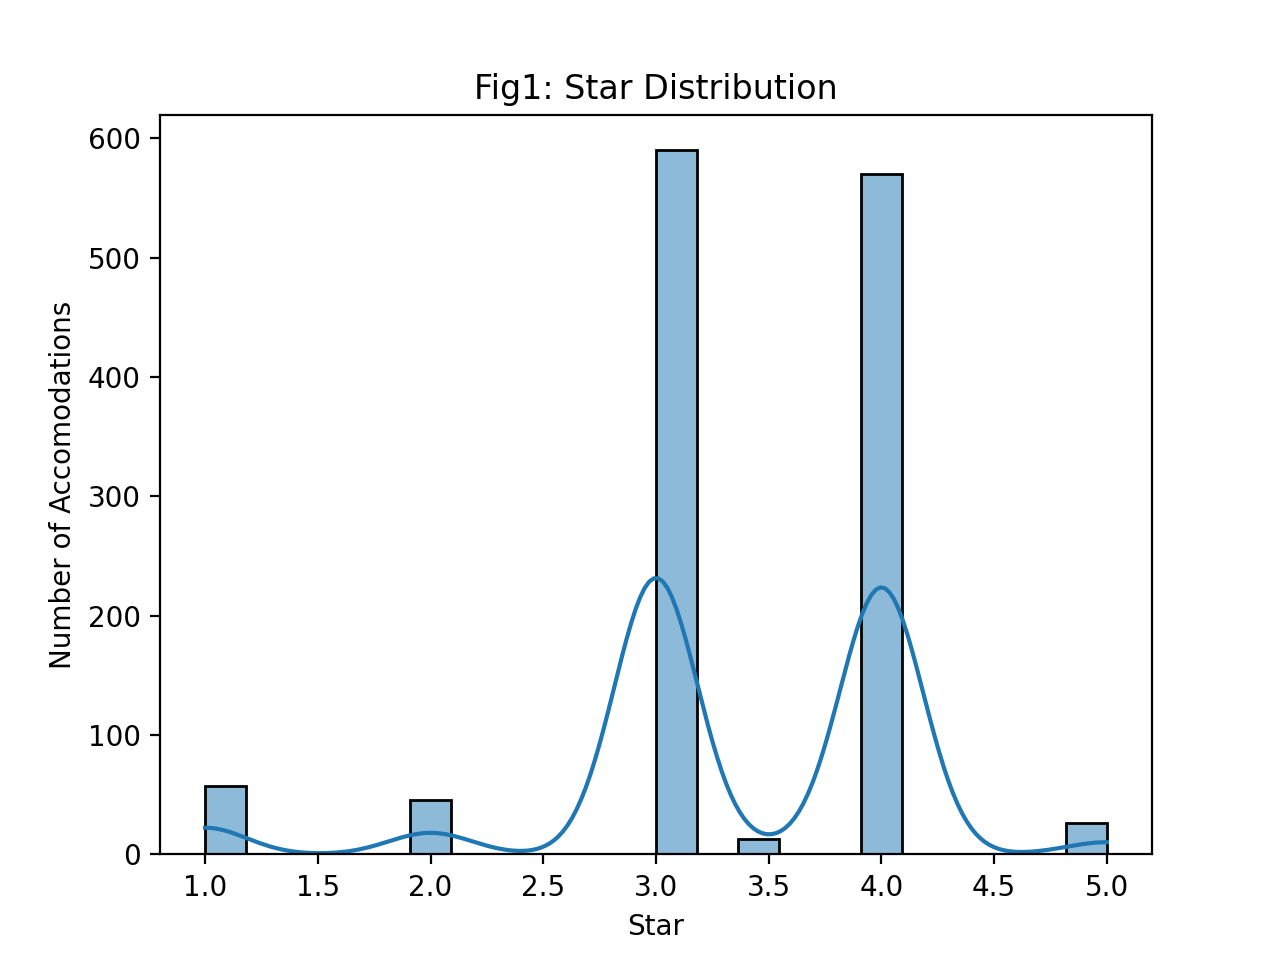

In [55]:
# Make a hist of the prices from the raw data
fig5 = sns.histplot(filtered_naples['stars'], kde=True)
fig5.set(title='Fig1: Star Distribution', xlabel='Star', ylabel='Number of Accomodations')
fig5

In [72]:
lpm1 = smf.ols("highly_rated ~ distance", data=filtered_naples).fit(cov_type="HC1")

In [73]:
lpm2 = smf.ols("highly_rated ~ distance + stars", data=filtered_naples).fit(cov_type="HC1")

In [74]:
stargazer = Stargazer([lpm1, lpm2])
stargazer.covariate_order(["distance", "stars", "Intercept"])
stargazer.rename_covariates({"Intercept": "Constant"})
stargazer